In [ ]:
#!pip install strawberryfields

In [1]:
import strawberryfields as sf
from strawberryfields.ops import *
from strawberryfields.utils import *

#eng, q = sf.Engine(2)

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [60]:
# Cutoff dimension
cutoff = 10

# Number of layers
depth = 21

# Number of steps in optimization routine performing gradient descent
reps = 1000

# Penalty coefficient to ensure the state is normalized
penalty_strength = 100

# Standard deviation of initial parameters
passive_sd = 0.1
active_sd = 0.001

In [61]:
# squeeze gate
sq_r = tf.Variable(tf.random_normal(shape=[depth], stddev=active_sd))
sq_phi = tf.Variable(tf.random_normal(shape=[depth], stddev=passive_sd))

# displacement gate
d_r = tf.Variable(tf.random_normal(shape=[depth], stddev=active_sd))
d_phi = tf.Variable(tf.random_normal(shape=[depth], stddev=passive_sd))

# rotation gates
r1 = tf.Variable(tf.random_normal(shape=[depth], stddev=passive_sd))
r2 = tf.Variable(tf.random_normal(shape=[depth], stddev=passive_sd))

# kerr gate
kappa = tf.Variable(tf.random_normal(shape=[depth], stddev=active_sd))

In [5]:
params = [r1, sq_r, sq_phi, r2,d_r, d_phi, kappa]

In [62]:
# layer architecture
def layer(i, q):
    Rgate(r1[i]) | q
    Sgate(sq_r[i], sq_phi[i]) | q
    Rgate(r2[i]) | q
    Dgate(d_r[i], d_phi[i]) | q
    Kgate(kappa[i]) | q

[0.         0.5        0.70710678 0.8660254  1.        ]


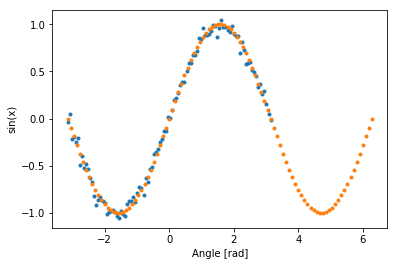

In [63]:
# Input data
import numpy as np
import matplotlib.pylab as plt

#Generate the sin data 
print(np.sin(np.array((0., 30., 45., 60., 90.)) * np.pi / 180. ))


#Create noise
noise = np.random.normal(0,1,100)
noise = noise* (0.05)

x_test = np.linspace(-np.pi, 2*np.pi, 100)
y_test = np.sin(x_test)
x = np.linspace(-np.pi, np.pi, 100)
y = np.sin(x) + noise
y_actual = np.sin(x)  
plt.plot(x, (y)  ,'.'  )
plt.plot(x_test, (y_test)  ,'.'  )
plt.xlabel('Angle [rad]')
plt.ylabel('sin(x)')
plt.axis('tight')
plt.show()

In [64]:
#x = [0,1,2]
inp = tf.Variable(x)
inp
batch_size = len(x)

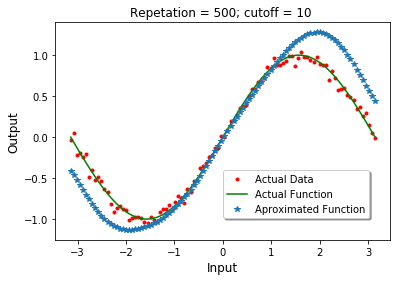

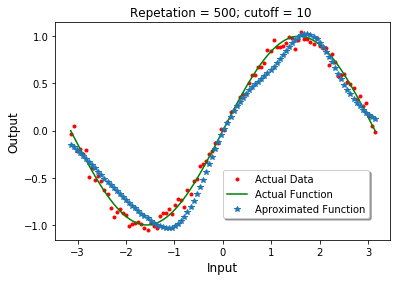

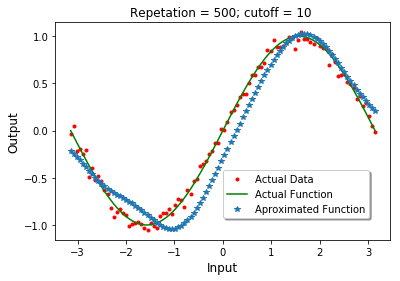

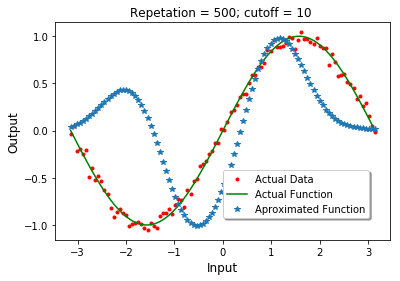

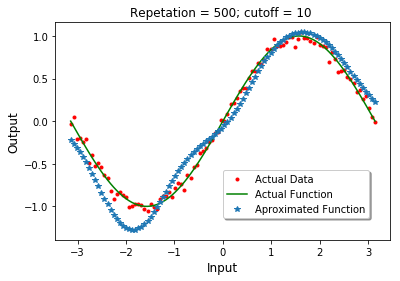

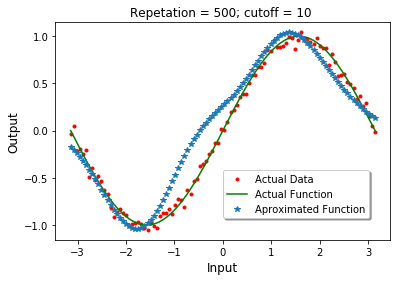

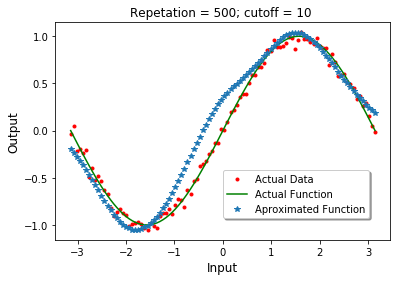

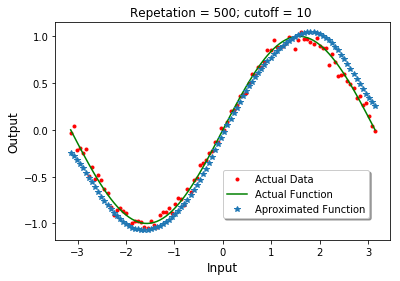

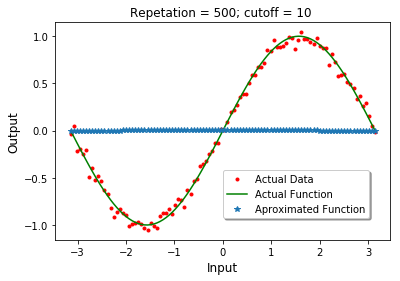

In [74]:
cum_Err = list()
y_All = dict()
dept_list = [2, 3, 4,5,6,8,10,12,16]
for depth in dept_list:
    engine, q = sf.Engine(1)

    # Apply circuit of layers with corresponding depth
    with engine:
        Dgate(inp) | q[0]
        for k in range(depth):

            layer(k, q[0])

    # Run engine
    state = engine.run('tf', cutoff_dim=cutoff, eval=False, batch_size=batch_size)
    ket = state.ket()

    prob = state.fock_prob([1])
    state
    expectation, var = state.quad_expectation(0)
    loss = tf.reduce_sum(( (y-expectation)**2 ) /len(x))

    # Set up optimization
    #optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.1)
    optimizer = tf.train.AdamOptimizer(learning_rate=0.1)
    minimize_op = optimizer.minimize(loss)
    
    sess = tf.Session()
    sess.run(tf.global_variables_initializer())
    
    reps = 500
    expectation_val_progress = list()
    fid_progress = []
    best_fid = 0

    # Run optimization
    for i in range(reps):

        # one repitition of the optimization
        _, loss_val, expectation_val, params_val = sess.run([minimize_op, loss,  expectation,  params])

        # Stores fidelity at each step
        expectation_val_progress.append(expectation_val)

        #print('Exp: {}'.format(expectation_val))
    
    
    y_test_predicted = sess.run(expectation, feed_dict={inp: x})
    y_test_predicted_2 = sess.run(expectation, feed_dict={inp: x_test})
    
    y_All[depth] = {'y_test_predicted':y_test_predicted, 'y_test_predicted_2': y_test_predicted_2}
    
    cum_Err.append( sum(np.power( (y_test_predicted-y_actual), 2)) )
    ###################
    fig, ax = plt.subplots()
    ax.plot(x, (y)  ,'.' , c= 'red', label='Actual Data' )
    ax.plot(x, y_actual  ,'-' , c= 'green', label='Actual Function' )
    ax.plot(x, y_test_predicted  ,'*', label='Aproximated Function'  )
    ax.set_xlabel('Input', fontsize=12)
    ax.set_ylabel('Output', fontsize=12)
    ax.set_title('Repetation = 500; cutoff = 10 ')
    legend = ax.legend(loc=[0.5,0.1], shadow=True, fontsize=10)
    ax.axis('tight')
    plt.savefig(str(depth)+'.jpg')
    plt.show()
cum_Err_dict = {'depth': dept_list,    'Err':cum_Err}

In [ ]:
import pickle
with open('Hack_Data.pickle', 'wb') as output:  # Overwrites any existing file.
    pickle.dump(y_All, output, pickle.HIGHEST_PROTOCOL)

In [113]:
#Saving Data for later use
import json

with open('Hackaton_Data_Err' , 'w') as f:
    f.write(json.dumps(cum_Err_dict)) # 

In [83]:
y_All[8]['y_test_predicted_2']

array([-1.7592734e-01, -2.2403418e-01, -2.8001797e-01, -3.4363845e-01,
       -4.1420278e-01, -4.9051893e-01, -5.7088846e-01, -6.5312856e-01,
       -7.3462760e-01, -8.1244469e-01, -8.8344145e-01, -9.4444060e-01,
       -9.9242073e-01, -1.0247080e+00, -1.0391864e+00, -1.0344733e+00,
       -1.0100604e+00, -9.6640515e-01, -9.0493494e-01, -8.2798111e-01,
       -7.3862445e-01, -6.4047825e-01, -5.3741312e-01, -4.3326509e-01,
       -3.3154821e-01, -2.3520048e-01, -1.4639139e-01, -6.6399291e-02,
        4.4290330e-03,  6.6635482e-02,  1.2154007e-01,  1.7106336e-01,
        2.1750644e-01,  2.6330161e-01,  3.1075579e-01,  3.6180815e-01,
        4.1781658e-01,  4.7939828e-01,  5.4633534e-01,  6.1755276e-01,
        6.9118470e-01,  7.6470482e-01,  8.3513892e-01,  8.9931780e-01,
        9.5416212e-01,  9.9696803e-01,  1.0256600e+00,  1.0389801e+00,
        1.0365937e+00,  1.0190902e+00,  9.8788261e-01,  9.4501579e-01,
        8.9292163e-01,  8.3415312e-01,  7.7114207e-01,  7.0601898e-01,
      

In [112]:
cum_Err_dict

{'Err': [6.799301751327268,
  1.273051388854735,
  2.9365796508868844,
  40.64294703583459,
  2.738861391558885,
  3.920046810228177,
  3.0859269812531593,
  1.2136237632432618,
  49.55859202868241],
 'depth': [2, 3, 4, 5, 6, 8, 10, 12, 16]}

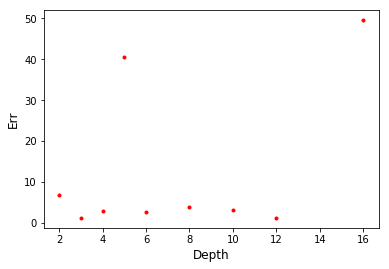

In [114]:
fig, ax1 = plt.subplots()
ax1.plot(cum_Err_dict['depth'], cum_Err_dict['Err'] ,'.' , c= 'red' )

ax1.set_xlabel('Depth', fontsize=12)
ax1.set_ylabel('Err', fontsize=12)
#ax.set_title('500 Repetation')
ax1.set_xlim(0, 12)
ax1.set_ylim(0, 100)

ax1.axis('tight')
plt.savefig('8_Out_of_Range_Predicted.jpg')
plt.show()

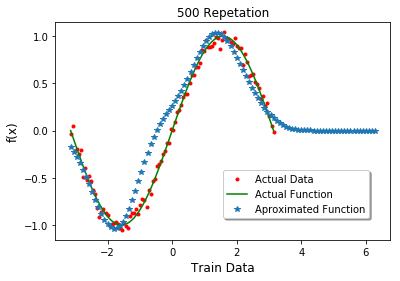

In [88]:
fig, ax = plt.subplots()
ax.plot(x, (y)  ,'.' , c= 'red', label='Actual Data' )
ax.plot(x, y_actual  ,'-' , c= 'green', label='Actual Function' )
ax.plot(x_test, y_All[8]['y_test_predicted_2']  ,'*', label='Aproximated Function'  )
ax.set_xlabel('Train Data', fontsize=12)
ax.set_ylabel('f(x)', fontsize=12)
ax.set_title('500 Repetation')
legend = ax.legend(loc=[0.5,0.1], shadow=True, fontsize=10)
ax.axis('tight')
plt.savefig('8_Out_of_Range_Predicted.jpg')
plt.show()

In [115]:
params[0].shape

TensorShape([Dimension(6)])

In [116]:
expectation_val


array([1.7122115e-05, 1.4836297e-05, 1.0059544e-04, 9.5330790e-05,
       1.6555659e-04, 1.2689014e-04, 5.2496837e-04, 3.7079747e-04,
       5.5876537e-04, 4.4627144e-04, 5.3169095e-04, 1.0284685e-03,
       1.2433035e-03, 1.3004723e-03, 1.8464674e-03, 1.5229436e-03,
       1.4647383e-03, 1.8014254e-03, 2.0739457e-03, 2.8145732e-03,
       2.7845320e-03, 2.7457953e-03, 2.7293991e-03, 2.7747247e-03,
       2.8092957e-03, 2.7962350e-03, 2.7323244e-03, 2.7980788e-03,
       2.8032155e-03, 2.2526302e-03, 1.8700077e-03, 1.8216735e-03,
       1.4700815e-03, 1.9431423e-03, 1.3656279e-03, 1.2310732e-03,
       1.2689264e-03, 1.3911191e-03, 1.3711606e-03, 9.9279324e-04,
       2.9364566e-03, 2.9390492e-03, 2.8520818e-03, 2.8440547e-03,
       2.8436696e-03, 2.7584729e-03, 2.6241441e-03, 2.3684076e-03,
       2.4000132e-03, 2.2872905e-03, 2.5071651e-03, 1.6012264e-03,
       2.2544335e-03, 2.3585761e-03, 5.1017778e-05, 2.6085629e-04,
       2.4730642e-03, 2.4137378e-03, 1.4016123e-03, 1.6559318e